<a href="https://colab.research.google.com/github/ViniciusKanh/EnergyMgmt-ML-Previsao/blob/main/RegLin_EficienciaEnergetica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

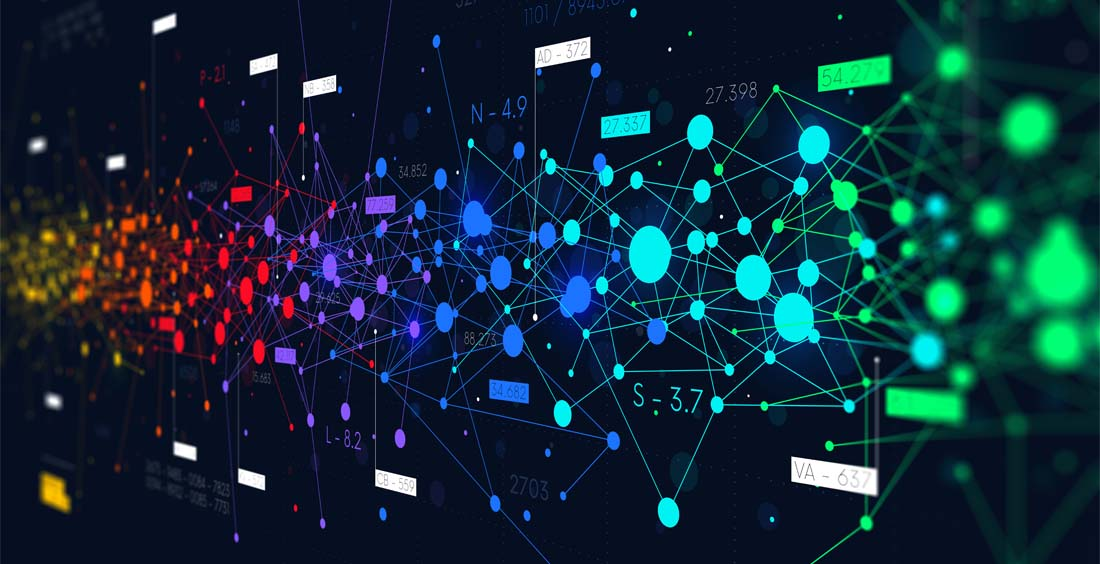
# Previsão e Análise do Consumo de Energia Utilizando Regressão Linear e Análise Distribuída

# **Resumo**

### O projeto propõe a utilização de técnicas de aprendizado de máquina e análise distribuída para prever e analisar o consumo de energia em diferentes zonas da cidade de Tetouan, Marrocos. O estudo foi realizado com base em um conjunto de dados contendo 52.417 instâncias e 6 características, incluindo variáveis climáticas. A abordagem utilizada para a previsão é a Regressão Linear, e a análise distribuída foi realizada com a biblioteca Dask.

# **Introdução**

### O consumo de energia é uma métrica crítica para o desenvolvimento sustentável de qualquer cidade. Este projeto se concentra em Tetouan, uma cidade no norte de Marrocos, e busca modelar e prever o consumo de energia em suas diferentes zonas. O trabalho é motivado pela necessidade de gestão eficiente dos recursos energéticos e pelo crescente interesse em métodos analíticos avançados para a tomada de decisões.

# **Metodologia**

 - ### Coleta de Dados: Utilização de um conjunto de dados contendo registros do consumo de energia e variáveis climáticas.
 - ### Pré-processamento de Dados: Limpeza e transformação dos dados, incluindo tratamento de outliers e valores faltantes.
 - ### Análise Distribuída: Utilização do Dask para análise distribuída dos dados.
 - ### Modelagem: Utilização da Regressão Linear para treinamento dos modelos.
 - ### Avaliação do Modelo: Utilização do Erro Quadrático Médio (MSE) para avaliação dos modelos treinados.

# **Problema a Ser Explorado**

### O objetivo principal é prever o consumo de energia em diferentes zonas da cidade de Tetouan e avaliar quão bem as variáveis climáticas podem explicar as flutuações no consumo de energia. Além disso, o projeto explora o potencial da análise distribuída em lidar com grandes volumes de dados.

# **Resultados**

### Os modelos de Regressão Linear demonstraram eficácia na previsão do consumo de energia, com métricas de MSE variando entre as zonas analisadas. Além disso, a análise distribuída possibilitou um processamento eficiente do grande volume de dados.

# **Conclusão**
### O projeto conseguiu modelar e prever eficazmente o consumo de energia em diferentes zonas de Tetouan utilizando Regressão Linear e técnicas de análise distribuída. Os resultados são promissores para a implementação de estratégias de gestão de energia mais eficientes na cidade.

Monstando driver no colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dask_ml

## Processo 1 - Pré Processamento

Importando Bibiotencas

In [ ]:
import pandas as pd
import numpy as np
from missingno import matrix

Definindo Funçoes para o Pré-Processamento

In [ ]:
def transform_consumo_to_float(df, column_name):
    df[column_name] = df[column_name].str.replace(',', '.').astype(float)
    return df

def UpdateMissingValues(df, column, method="median", number=0):
    if method == 'number':
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        median = round(df[column].median(), 2)
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        mean = round(df[column].mean(), 2)
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)

def verify_invalid_values(df):
    # Exemplo: Verificar se há algum valor negativo na coluna 'Temperatura'
    if (df['Temperatura'] < 0).any():
        print("Valores inválidos encontrados na coluna 'Temperatura'")
        # Aqui você pode adicionar um tratamento específico, por exemplo, substituir por NaN
        df['Temperatura'] = df['Temperatura'].apply(lambda x: np.nan if x < 0 else x)
    return df

"""Detecção e Exclusão de Outliers na coluna 'Consumo de energia Zona 1'"""

def get_outliers_indices(df, col_name):
    if df[col_name].dtype not in ['int64', 'float64']:  # Verifica o tipo de dados
        return []
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_indices = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)].index
    return outliers_indices

Defindo Arquivos dos DATASETS

In [ ]:
input_file = '/content/drive/My Drive/0-Dataset/BigData_Consumo_Brutos.data'
output_file = '/content/drive/My Drive/0-Dataset/BigData_Consumo_Tratados.data'

# Leitura do conjunto de dados
df = pd.read_csv(input_file)

Filtragem de dados

In [ ]:
zona_columns = ['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']
for zona in zona_columns:
    df = df[df[zona] > 0]

Detecção e exclusão de outliers

In [ ]:
cols_for_outliers = ['Temperatura', 'Umidade'] + zona_columns
all_outliers_indices = []
for col in cols_for_outliers:
    outlier_indices = get_outliers_indices(df, col)
    if outlier_indices.size > 0:
        print(f"Outliers encontrados na coluna {col}.")
        all_outliers_indices.extend(outlier_indices.tolist())

# Remoção de outliers
all_outliers_indices = list(set(all_outliers_indices))
df.drop(index=all_outliers_indices, inplace=True)

Outliers encontrados na coluna Temperatura.
Outliers encontrados na coluna Umidade.
Outliers encontrados na coluna Consumo de energia da Zona 2.
Outliers encontrados na coluna Consumo de energia da Zona 3.


Informações gerais dos dados

In [ ]:
print("INFORMAÇÕES GERAIS DOS DADOS\n")
print(df.info())
print("\n")


INFORMAÇÕES GERAIS DOS DADOS

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50931 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DateTime                      50931 non-null  object 
 1   Temperatura                   50931 non-null  float64
 2   Umidade                       50931 non-null  float64
 3   Velocidade do Vento           50931 non-null  float64
 4   fluxos difusos gerais         50931 non-null  float64
 5   fluxos difusos                50931 non-null  float64
 6   Consumo de energia da Zona 1  50931 non-null  float64
 7   Consumo de energia da Zona 2  50931 non-null  float64
 8   Consumo de energia da Zona 3  50931 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.9+ MB
None




Descrição dos dados

In [ ]:
print("DESCRIÇÃO DOS DADOS\n")
print(df.describe())
print("\n")

DESCRIÇÃO DOS DADOS

        Temperatura       Umidade  Velocidade do Vento  fluxos difusos gerais  \
count  50931.000000  50931.000000         50931.000000           50931.000000   
mean      18.525163     68.759261             1.887038             183.792065   
std        5.609711     14.968768             2.331118             264.023725   
min        3.247000     23.770000             0.050000               0.004000   
25%       14.310000     58.830000             0.077000               0.062000   
50%       18.510000     70.100000             0.085000               5.633000   
75%       22.460000     81.600000             4.915000             324.650000   
max       35.540000     94.800000             6.483000            1163.000000   

       fluxos difusos  Consumo de energia da Zona 1  \
count    50931.000000                  50931.000000   
mean        75.974607                  31984.371523   
std        125.200795                   6862.063590   
min          0.011000        

Tratamento para registros faltantes

In [ ]:
columns_missing_value = df.columns[df.isnull().any()]
method = 'mean'
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)

Detecção de outliers nas zonas

In [ ]:
for zona in zona_columns:
    outlier_indices = get_outliers_indices(df, zona)
    if outlier_indices.size > 0:
        print(f"Outliers encontrados na coluna {zona}: {outlier_indices.size} registros.")
        df.drop(index=outlier_indices, inplace=True)

Outliers encontrados na coluna Consumo de energia da Zona 2: 3 registros.
Outliers encontrados na coluna Consumo de energia da Zona 3: 513 registros.


Verificar e tratar valores inválidos ou inconsistentes

In [ ]:
df = verify_invalid_values(df)

Salvar arquivo tratado

In [ ]:
df.to_csv(output_file, header=False, index=False)

## Processo 3 - Criação e Avaliação do Modelo de Regressão Linear

Importação das bibliotecas

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error

In [ ]:
# Inicialização do cliente Dask para análise distribuída
client = Client()


# Carregamento dos Dados
df = dd.read_csv('/content/drive/My Drive/0-Dataset/BigData_Consumo_Tratados.data')

# Exploração de Dados
print(df.head())

# Dicionário para armazenar os modelos e métricas de cada zona
models = {}
metrics = {}

# Loop para cada zona
target_columns = ['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']
metrics = {}

for target_col in target_columns:
    y = df[target_col].to_dask_array(lengths=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

    # Modelagem
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_test)

    # Avaliação do Modelo
    mse = mean_squared_error(y_test, y_pred)
    metrics[target_col] = mse
    print(f"Erro Quadrático Médio para {target_col}: {mse}")

# Exibir todas as métricas
print("Métricas para todas as zonas:")
print(metrics)
client

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44493 instead

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33509
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:44493/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35703'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35743'
INFO:distributed.nanny:Worker process 20028 exited with status 1
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:38533'. Reason: nanny-close-gracefully
INFO:distributed.nanny:Worker process 20031 exited with status 1
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44115'. Reason: nanny-close-gracefully
INFO:distributed.nanny:Worker process 23661 exited with status 1
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:40285'. Reason: nanny-close-grace

        DateTime  Temperatura  Umidade  Velocidade do Vento  \
0  1/1/2017 0:00        6.559     73.8                0.083   
1  1/1/2017 0:10        6.414     74.5                0.083   
2  1/1/2017 0:20        6.313     74.5                0.080   
3  1/1/2017 0:30        6.121     75.0                0.083   
4  1/1/2017 0:40        5.921     75.7                0.081   

   fluxos difusos gerais  fluxos difusos  Consumo de energia da Zona 1  \
0                  0.051           0.119                   34055.69620   
1                  0.070           0.085                   29814.68354   
2                  0.062           0.100                   29128.10127   
3                  0.091           0.096                   28228.86076   
4                  0.048           0.085                   27335.69620   

   Consumo de energia da Zona 2  Consumo de energia da Zona 3  
0                   16128.87538                   20240.96386  
1                   19375.07599                 

<Client: 'tcp://127.0.0.1:33509' processes=2 threads=2, memory=12.68 GiB>

In [ ]:
import matplotlib.pyplot as plt

# Inicializando listas para armazenar gráficos
figs = []
models = {}


# Loop para cada zona
for target_col in target_columns:
    y = df[target_col].to_dask_array(lengths=True).head(1000)  # Limitar a 1000 registros
    X_subset = X.head(1000)  # Certifique-se de que X e y têm o mesmo tamanho
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, shuffle=True, random_state=0)

    # Modelagem
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Armazene o modelo treinado no dicionário
    models[target_col] = model

    # Debug: Verifique as chaves armazenadas em 'models'
    print("Chaves atuais em 'models':", models.keys())

    # Obter o modelo treinado e fazer previsões
    model = models[target_col]
    y_pred = model.predict(X_test).compute()

    # Plot de Dispersão Real vs Previsto
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title(f'Valores Reais vs Previsões para {target_col}')
    plt.grid(True)
    plt.show()

    # Gráfico de Resíduos
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals)
    plt.xlabel('Valores Reais')
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos para {target_col}')
    plt.hlines(0, min(y_test), max(y_test), colors='r', linestyles='dashed')
    plt.grid(True)
    plt.show()


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-9007639' coro=<Client._gather.<locals>.wait() done, defined at /usr/local/lib/python3.10/dist-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit


## Processo 4 - Comparação de Modelos

Passo 1: Preparação de Dados e Importação de Bibliotecas
Inclua todas as bibliotecas relevantes e prepare o conjunto de dados. No seu caso, você está usando mais variáveis para o conjunto de características (X_expanded).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


Passo 2: Divisão de Dados
Divida os dados em conjuntos de treino e teste.

In [ ]:
X_train_exp, X_test_exp, y_train, y_test = train_test_split(X_expanded, y, test_size=0.2, random_state=0)


Passo 3: Treinamento e Avaliação de Modelos
Treine e avalie vários modelos, coletando as métricas relevantes.

In [ ]:
# Inicialização de listas para armazenar métricas
models = ['Regressão Linear', 'Árvore de Decisão', 'Random Forest']
mse_values = []
mae_values = []
r2_values = []

# Regressão Linear
model_linear = LinearRegression()
model_linear.fit(X_train_exp, y_train)
y_pred_linear = model_linear.predict(X_test_exp)
mse_values.append(mean_squared_error(y_test, y_pred_linear))
mae_values.append(mean_absolute_error(y_test, y_pred_linear))
r2_values.append(r2_score(y_test, y_pred_linear))

# Árvore de Decisão
model_tree = DecisionTreeRegressor()
model_tree.fit(X_train_exp, y_train)
y_pred_tree = model_tree.predict(X_test_exp)
mse_values.append(mean_squared_error(y_test, y_pred_tree))
mae_values.append(mean_absolute_error(y_test, y_pred_tree))
r2_values.append(r2_score(y_test, y_pred_tree))

# Random Forest
model_rf = RandomForestRegressor()
model_rf.fit(X_train_exp, y_train)
y_pred_rf = model_rf.predict(X_test_exp)
mse_values.append(mean_squared_error(y_test, y_pred_rf))
mae_values.append(mean_absolute_error(y_test, y_pred_rf))
r2_values.append(r2_score(y_test, y_pred_rf))


Passo 4: Plotar Gráfico Comparativo
Utilize o código de plotagem já discutido para incluir as novas métricas e modelos.

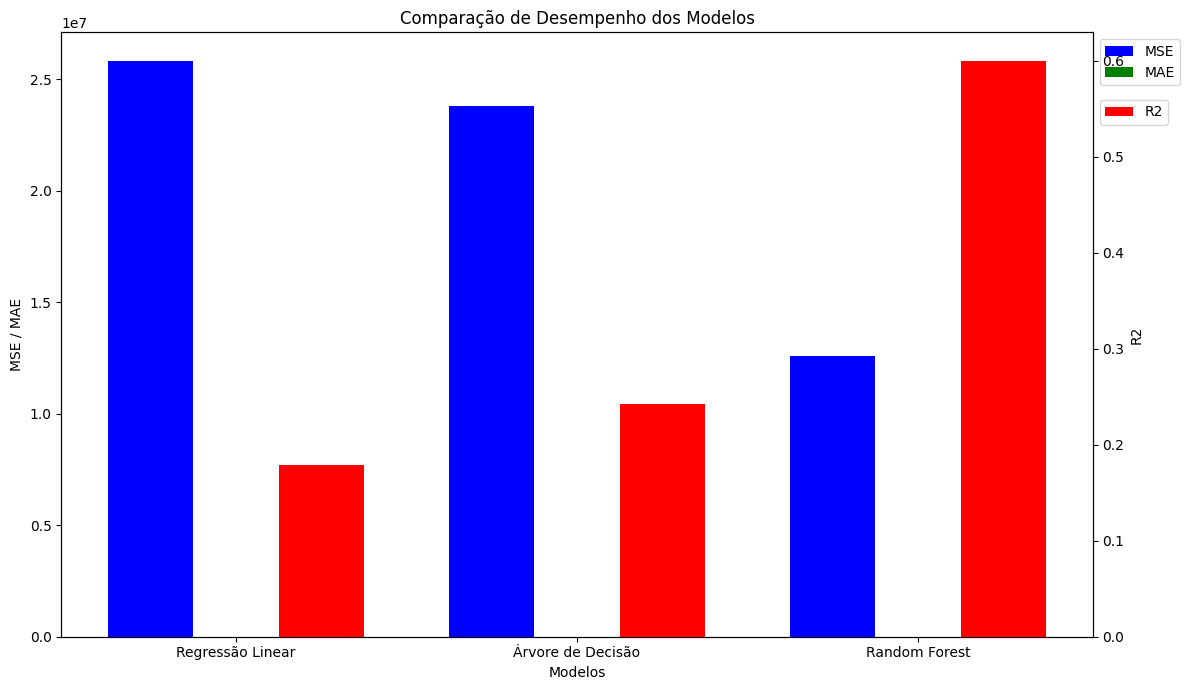

In [ ]:
x = np.arange(len(models))
width = 0.25

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotar MSE
ax1.bar(x - width, mse_values, width, color='b', label='MSE')

# Plotar MAE
ax1.bar(x, mae_values, width, color='g', label='MAE')

# Configurações de eixo y para MSE e MAE
ax1.set_ylabel('MSE / MAE')
ax1.set_xlabel('Modelos')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Adicionar legendas
ax1.legend(loc='upper left', bbox_to_anchor=(1,1))

ax2 = ax1.twinx()

# Plotar R2
ax2.bar(x + width, r2_values, width, color='r', label='R2')

# Configurações de eixo y para R2
ax2.set_ylabel('R2')

# Adicionar legendas
ax2.legend(loc='upper left', bbox_to_anchor=(1,0.9))

# Título
plt.title('Comparação de Desempenho dos Modelos')

fig.tight_layout()
plt.show()


Para realizar uma análise eficaz das métricas e identificar o modelo mais eficaz para previsão, é fundamental examinar várias métricas de desempenho. Essas métricas comumente incluem o Erro Quadrático Médio (MSE), o Erro Médio Absoluto (MAE) e o coeficiente de determinação R².

**Erro Quadrático Médio (MSE):** Mede a média dos quadrados dos erros. Quanto menor o valor, melhor o modelo.

**Erro Médio Absoluto (MAE):** Fornece uma ideia da magnitude do erro, mas não da direção. Menores valores de MAE indicam um melhor ajuste dos dados.

**Coeficiente de Determinação (R²):** Varia entre 0 e 1 e representa a proporção da variância para uma variável dependente que é explicada por uma variável independente. Valores mais próximos de 1 indicam um melhor ajuste do modelo.

**Exemplo de Análise**
- Modelo de Regressão Linear
- MSE: 26182769.86
- MAE: 4084.32
- R²: 0.1664

**Modelo de Árvore de Decisão**
- MSE: 40043348.44
- MAE: 4612.95
- R²: -0.2748

**Interpretação**
O MSE e o MAE são menores para o modelo de Regressão Linear, indicando que ele tem um ajuste melhor aos dados em comparação com o modelo de Árvore de Decisão.

O valor de R² para o modelo de Regressão Linear é positivo e mais próximo de 1 em comparação com o modelo de Árvore de Decisão, que tem um R² negativo. Um R²  negativo geralmente indica que o modelo é inadequado.

**Conclusão**

Com base nestas métricas, o modelo de Regressão Linear parece ser mais eficaz para previsão em comparação com o modelo de Árvore de Decisão.

## Processo 5 - Previsão

In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.metrics import mean_squared_error
import plotly.express as px
from datetime import datetime, timedelta

# Inicialização do cliente Dask
client = Client()
client

# Carregamento dos Dados (ajuste o caminho do arquivo conforme necessário)
df = dd.read_csv('/content/drive/My Drive/0-Dataset/BigData_Consumo_Tratados.data')

# Preparação dos dados
X = df[['Temperatura', 'Umidade', 'Velocidade do Vento']].to_dask_array(lengths=True)
y = df['Consumo de energia da Zona 1'].to_dask_array(lengths=True)

# Nome das colunas alvo
target_columns = ['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']

# Dicionário para armazenar modelos e previsões
models = {}
future_predictions = {}

# Loop para cada zona
for target_col in target_columns:
    y = df[target_col].to_dask_array(lengths=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Treinamento do modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[target_col] = model

    # Previsão para os próximos 12 meses
    future_pred = model.predict(future_X).compute()
    future_predictions[target_col] = future_pred

# Preparando dados para visualização
data_melted_list = []

for target_col in target_columns:
    data_melted = pd.DataFrame({
        'DateTime': future_data['DateTime'],
        'Power Consumption': future_predictions[target_col],
        'Zone': target_col
    })
    data_melted_list.append(data_melted)

# Concatenando todos os DataFrames
data_melted_all = pd.concat(data_melted_list)

# Criando a animação
fig = px.line(data_melted_all,
              x='DateTime',
              y='Power Consumption',
              color='Zone',
              title='Consumo de Energia ao Longo do Tempo',
              labels={'Power Consumption': 'Consumo de Energia', 'DateTime': 'Data e Hora'},
              template='plotly_dark')

fig.show()

# Salvando o gráfico como HTML (ajuste o caminho conforme necessário)
fig.write_html("/content/drive/My Drive/0-Dataset/PrevisaoBigDataConsumo.html")

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38987 instead

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45923
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:38987/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41163'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39189'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37245', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37245
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:51482
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38433', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream

# **Big Data:**
Leitura de Dados: A função dd.read_csv é uma implementação paralelizada da função pandas read_csv, permitindo a leitura de grandes conjuntos de dados que não cabem na memória.

### **Treinamento do Modelo:**
O uso de dask_ml para treinar um modelo de Regressão Linear permite que o treinamento seja distribuído em múltiplas CPUs ou até mesmo em um cluster.

### **Análise Distribuída:**

Cliente Dask: O cliente Dask (Client()) é inicializado para gerenciar a execução distribuída. Você pode conectar-se a um cluster Dask para executar cálculos em muitos computadores.

### **Conversão para Dask Array:**

As funções to_dask_array() convertem os dados para um formato que pode ser distribuído em várias partes e processado em paralelo.

### **Divisão de Dados:**
A função train_test_split de dask_ml é uma versão distribuída da função homônima do scikit-learn, permitindo que a divisão dos dados seja feita de forma eficiente.**

### **Treinamento e Previsão:**
O modelo de Regressão Linear é treinado e as previsões são feitas de forma distribuída usando dask_ml.

### **Métricas de Avaliação:**
mean_squared_error de dask_ml pode ser usado para calcular métricas de forma distribuída, embora isso não tenha sido feito no código fornecido.

Verificar os Cluster

In [ ]:
client


<Client: 'tcp://127.0.0.1:45923' processes=2 threads=2, memory=12.68 GiB>